## Task-2

# Data Generation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate XOR dataset with noise
np.random.seed(42)
torch.manual_seed(42)
N = 200  # Instances for training and test each
noise = 0.1

# XOR pattern
X = np.random.rand(2 * N, 2) * 2 - 1  # Range -1 to 1
X_N = np.random.rand(2 * N, 2) * 2 - 1  # Range -1 to 1
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

# # Add Gaussian noise
X_N += noise * np.random.randn(*X.shape)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

XN_train, XN_test, yn_train, yn_test = train_test_split(X_N, y, test_size=0.5, random_state=42)
XN_train, XN_val, yn_train, yn_val = train_test_split(XN_train, yn_train, test_size=0.2, random_state=42)

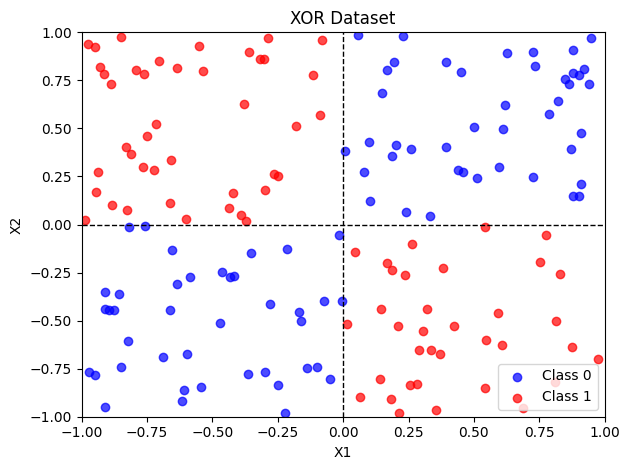

In [2]:
import matplotlib.pyplot as plt


# First subplot (scatter plot of Class 0)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue', label='Class 0', alpha=0.7)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red', label='Class 1', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.title('XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()


# Adjust layout
plt.tight_layout()
plt.show()


In [3]:
X_train, y_train, X_val, y_val,X_test, y_test = torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(X_val), torch.Tensor(y_val), torch.Tensor(X_test), torch.Tensor(y_test)
XN_train, yn_train, XN_val, yn_val,XN_test, yn_test = torch.Tensor(XN_train), torch.Tensor(yn_train), torch.Tensor(XN_val), torch.Tensor(yn_val), torch.Tensor(XN_test), torch.Tensor(yn_test)

In [4]:
def plot_decision_boundary(model, X, y, title, feature_transform=None, ax=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    if feature_transform:
        grid = feature_transform(grid)

    with torch.no_grad():
        zz = model(grid).reshape(xx.shape)

    # Plot on the provided Axes object
    if ax is None:
        ax = plt.gca()  # Use current Axes if none provided
    ax.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap="coolwarm")
    ax.set_title(title)


In [5]:
# def plot_decision_boundary(model, X, y, title, feature_transform=None):
#     x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
#     y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
#                          np.arange(y_min, y_max, 0.01))
#     grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

#     if feature_transform:
#         grid = feature_transform(grid)

#     with torch.no_grad():
#         zz = model(grid).reshape(xx.shape)
#     plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.8)
#     plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap="coolwarm")
#     plt.title(title)
#     plt.show()

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, l1=0.0, l2=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.l1 = l1
        self.l2 = l2

    def forward(self, x):
        # Forward pass through all layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x)).squeeze()

    def regularization_loss(self):
        # Compute L1 and L2 regularization losses
        l1_loss = self.l1 * sum(torch.abs(param).sum() for param in self.parameters())
        l2_loss = self.l2 * sum((param ** 2).sum() for param in self.parameters())
        return l1_loss + l2_loss

In [7]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=500, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Add regularization loss
        if isinstance(model, MLP):
            loss += model.regularization_loss()

        loss.backward()
        optimizer.step()

        # Print accuracy every 50 epochs
        if (epoch + 1) % 50 == 0:
            test_pred = model(X_val).round()
            accuracy = accuracy_score(y_val, test_pred.detach().numpy())
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Accuracy: {accuracy:.2f}')

## MLP

In [8]:
# Train MLP without regularization
mlp = MLP(input_dim=2, hidden_dim=10)
train_model(mlp, X_train, y_train, X_val, y_val)

Epoch 50/500, Loss: 0.490572452545166, Val Accuracy: 0.85
Epoch 100/500, Loss: 0.17551544308662415, Val Accuracy: 0.95
Epoch 150/500, Loss: 0.08321834355592728, Val Accuracy: 0.95
Epoch 200/500, Loss: 0.05417720600962639, Val Accuracy: 0.95
Epoch 250/500, Loss: 0.03872145712375641, Val Accuracy: 0.93
Epoch 300/500, Loss: 0.029503589496016502, Val Accuracy: 0.93
Epoch 350/500, Loss: 0.02357383258640766, Val Accuracy: 0.93
Epoch 400/500, Loss: 0.019237782806158066, Val Accuracy: 0.93
Epoch 450/500, Loss: 0.016185175627470016, Val Accuracy: 0.93
Epoch 500/500, Loss: 0.013932639732956886, Val Accuracy: 0.93


In [9]:
np.random.seed(42)
torch.manual_seed(42)

# Train MLP without regularization
mlp_N = MLP(input_dim=2, hidden_dim=10)
train_model(mlp_N, XN_train, yn_train, XN_val, yn_val)

Epoch 50/500, Loss: 0.6563259959220886, Val Accuracy: 0.88
Epoch 100/500, Loss: 0.6291106939315796, Val Accuracy: 0.85
Epoch 150/500, Loss: 0.6236069798469543, Val Accuracy: 0.85
Epoch 200/500, Loss: 0.6179763674736023, Val Accuracy: 0.85
Epoch 250/500, Loss: 0.6092126369476318, Val Accuracy: 0.82
Epoch 300/500, Loss: 0.6036316752433777, Val Accuracy: 0.80
Epoch 350/500, Loss: 0.6008274555206299, Val Accuracy: 0.80
Epoch 400/500, Loss: 0.5987541079521179, Val Accuracy: 0.80
Epoch 450/500, Loss: 0.5970128178596497, Val Accuracy: 0.78
Epoch 500/500, Loss: 0.5956424474716187, Val Accuracy: 0.80


In [10]:
# Test MLP without regularization
mlp.eval()
with torch.no_grad():
    test_pred = mlp(X_test).round()  # Get predictions

# Calculate accuracy
test_accuracy_mlp = accuracy_score(y_test.numpy(), test_pred.numpy())
print(f'Test Accuracy (MLP without regularization): {test_accuracy_mlp:.2f}')

Test Accuracy (MLP without regularization): 0.97


In [11]:
# Test MLP without regularization
mlp_N.eval()
with torch.no_grad():
    test_pred = mlp_N(X_test).round()  # Get predictions

# Calculate accuracy
test_accuracy_mlp = accuracy_score(y_test.numpy(), test_pred.numpy())
print(f'Test Accuracy (MLP without regularization): {test_accuracy_mlp:.2f}')

Test Accuracy (MLP without regularization): 0.72


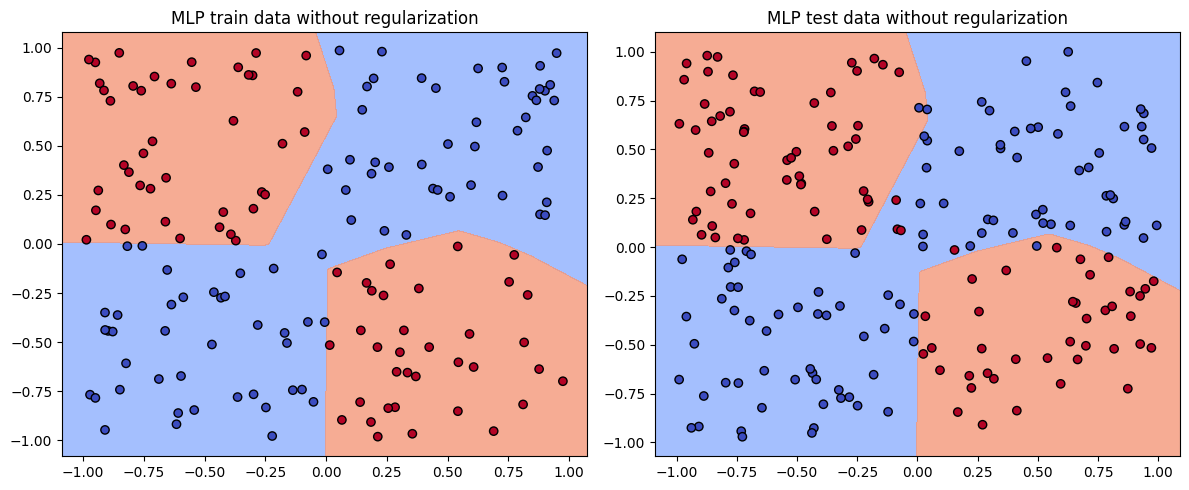

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Call the plot_decision_boundary function on each subplot
plot_decision_boundary(mlp, X_train.numpy(), y_train.numpy(), "MLP train data without regularization", ax=axs[0])
plot_decision_boundary(mlp, X_test.numpy(), y_test.numpy(), "MLP test data without regularization", ax=axs[1])

# Adjust layout
plt.tight_layout()
plt.show()


#comments

1. The decision boundaries for both training and test data exhibit clear, nonlinear regions capturing the XOR pattern.
2. The model appears to fit well on the training data, but the boundaries may slightly overfit since there is no regularization.
3. The test data plot shows similar decision boundaries but with some regions where the model is less confident, indicating slight generalization issues.

## MLP with L1 Regularization

In [13]:
np.random.seed(42)
torch.manual_seed(42)

# Train MLP with L1 regularization
mlp_l1_old = MLP(input_dim=2, hidden_dim=10, output_dim=1, l1=0.01)
train_model(mlp_l1_old, X_train, y_train, X_val, y_val)

Epoch 50/500, Loss: 0.7092534303665161, Val Accuracy: 0.53
Epoch 100/500, Loss: 0.695122480392456, Val Accuracy: 0.53
Epoch 150/500, Loss: 0.694847822189331, Val Accuracy: 0.53
Epoch 200/500, Loss: 0.6949096322059631, Val Accuracy: 0.53
Epoch 250/500, Loss: 0.695030152797699, Val Accuracy: 0.53
Epoch 300/500, Loss: 0.6950190663337708, Val Accuracy: 0.53
Epoch 350/500, Loss: 0.6947836875915527, Val Accuracy: 0.53
Epoch 400/500, Loss: 0.6948773860931396, Val Accuracy: 0.53
Epoch 450/500, Loss: 0.6950241327285767, Val Accuracy: 0.53
Epoch 500/500, Loss: 0.6949355602264404, Val Accuracy: 0.53


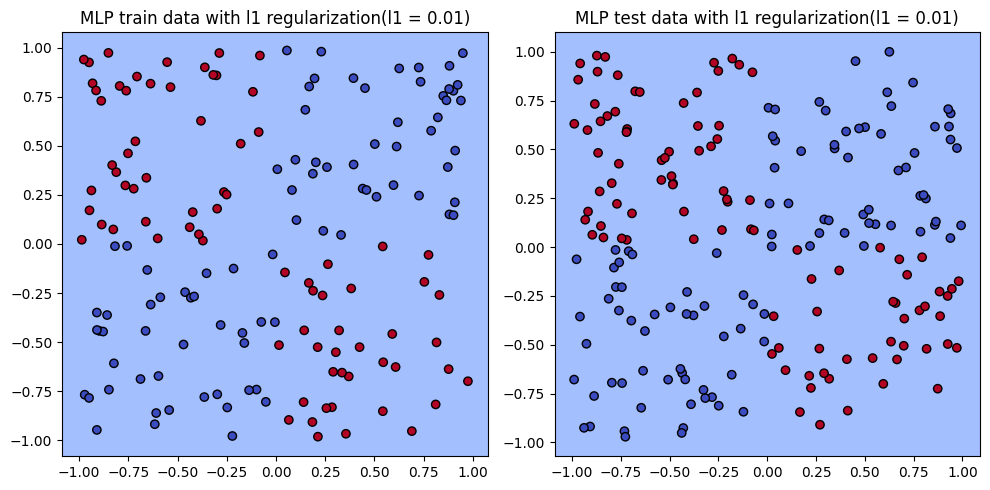

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Call the plot_decision_boundary function on each subplot
plot_decision_boundary(mlp_l1_old, X_train.numpy(), y_train.numpy(), "MLP train data with l1 regularization(l1 = 0.01)", ax=axs[0])
plot_decision_boundary(mlp_l1_old, X_test.numpy(), y_test.numpy(), "MLP test data with l1 regularization(l1 = 0.01)", ax=axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:

# Train MLP with L1 regularization
mlp_l1 = MLP(input_dim=2, hidden_dim=10, output_dim=1, l1=0.001)
train_model(mlp_l1, X_train, y_train, X_val, y_val)

Epoch 50/500, Loss: 0.4685407280921936, Val Accuracy: 0.78
Epoch 100/500, Loss: 0.1785011738538742, Val Accuracy: 0.97
Epoch 150/500, Loss: 0.1394047737121582, Val Accuracy: 1.00
Epoch 200/500, Loss: 0.12752047181129456, Val Accuracy: 0.97
Epoch 250/500, Loss: 0.1213095486164093, Val Accuracy: 0.97
Epoch 300/500, Loss: 0.11707663536071777, Val Accuracy: 0.97
Epoch 350/500, Loss: 0.11374612897634506, Val Accuracy: 0.97
Epoch 400/500, Loss: 0.11095564812421799, Val Accuracy: 0.97
Epoch 450/500, Loss: 0.10840679705142975, Val Accuracy: 0.97
Epoch 500/500, Loss: 0.1057182252407074, Val Accuracy: 0.97


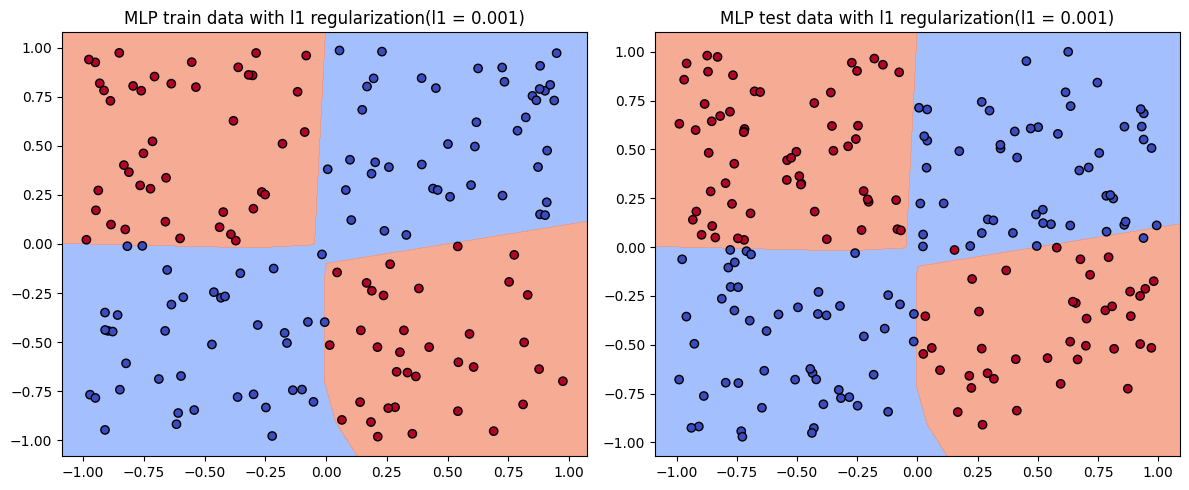

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Call the plot_decision_boundary function on each subplot
plot_decision_boundary(mlp_l1, X_train.numpy(), y_train.numpy(), "MLP train data with l1 regularization(l1 = 0.001)", ax=axs[0])
plot_decision_boundary(mlp_l1, X_test.numpy(), y_test.numpy(), "MLP test data with l1 regularization(l1 = 0.001)", ax=axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# Test MLP without regularization
mlp_l1.eval()
with torch.no_grad():
    test_pred = mlp_l1(X_test).round()  # Get predictions

# Calculate accuracy
test_accuracy = accuracy_score(y_test.numpy(), test_pred.numpy())
print(f'Test Accuracy (MLP with L1 regularization): {test_accuracy:.2f}')

Test Accuracy (MLP with L1 regularization): 0.99


#Comments

1. With L1 regularization, the decision boundaries are less complex, as the model coefficients are regularized, leading to sparser weights.
2. The boundaries are still able to capture the XOR shape, but they are somewhat simplified compared to the model without regularization, suggesting reduced overfitting.
3. The test data shows similar decision boundaries, indicating slightly improved generalization compared to the model without regularization.

## MLP with L2 Regularisation

In [18]:

#  Train MLP with L2 regularization
mlp_l2 = MLP(input_dim=2, hidden_dim=8, output_dim=1, l2=0.001)
train_model(mlp_l2, X_train, y_train, X_val, y_val)

Epoch 50/500, Loss: 0.3990517854690552, Val Accuracy: 0.85
Epoch 100/500, Loss: 0.18461929261684418, Val Accuracy: 0.97
Epoch 150/500, Loss: 0.12342590093612671, Val Accuracy: 0.97
Epoch 200/500, Loss: 0.11473904550075531, Val Accuracy: 0.97
Epoch 250/500, Loss: 0.11134982854127884, Val Accuracy: 0.97
Epoch 300/500, Loss: 0.10949386656284332, Val Accuracy: 0.97
Epoch 350/500, Loss: 0.10823342204093933, Val Accuracy: 0.97
Epoch 400/500, Loss: 0.1073676347732544, Val Accuracy: 0.97
Epoch 450/500, Loss: 0.10681981593370438, Val Accuracy: 0.97
Epoch 500/500, Loss: 0.10647733509540558, Val Accuracy: 0.97


In [19]:
# Test MLP without regularization
mlp_l2.eval()
with torch.no_grad():
    test_pred = mlp_l2(X_test).round()  # Get predictions

# Calculate accuracy
test_accuracy = accuracy_score(y_test.numpy(), test_pred.numpy())
print(f'Test Accuracy (MLP with L2 regularization): {test_accuracy:.2f}')

Test Accuracy (MLP with L2 regularization): 0.99


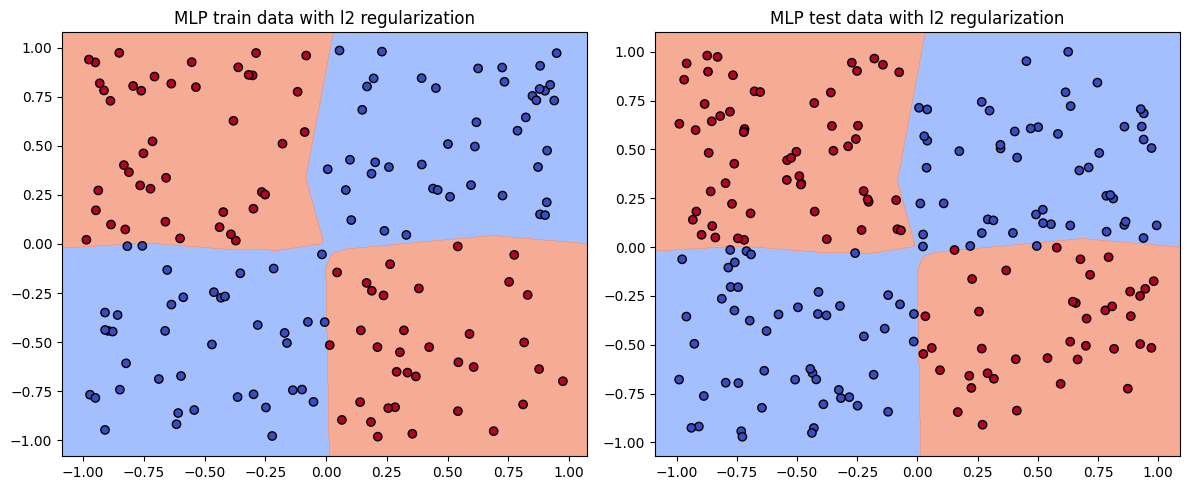

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Call the plot_decision_boundary function on each subplot
plot_decision_boundary(mlp_l2, X_train.numpy(), y_train.numpy(), "MLP train data with l2 regularization", ax=axs[0])
plot_decision_boundary(mlp_l2, X_test.numpy(), y_test.numpy(), "MLP test data with l2 regularization", ax=axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

#Comments

1. The L2-regularized model also exhibits simplified decision boundaries, though the boundaries retain a smooth shape compared to L1 regularization.
2. This model seems to strike a balance between fitting the XOR pattern and maintaining smooth decision regions, which might help with generalization.
3. On the test data, the decision boundaries remain consistent, showing improved stability compared to the unregularized model.

## Logistic Regression

In [21]:
# Adding engineered features to XOR dataset
X_train_ext = torch.cat([torch.Tensor(X_train),
                          torch.Tensor(X_train[:, 0:1] * X_train[:, 1:2]),
                          torch.Tensor(X_train[:, 0:1] ** 2),
                          torch.Tensor(X_train[:, 1:2] ** 2)], dim=1)

X_test_ext = torch.cat([torch.Tensor(X_test),
                         torch.Tensor(X_test[:, 0:1] * X_test[:, 1:2]),
                         torch.Tensor(X_test[:, 0:1] ** 2),
                         torch.Tensor(X_test[:, 1:2] ** 2)], dim=1)

# Convert target variables to tensors
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

# Define the logistic regression model
class LogisticRegressionWithFeatures(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionWithFeatures, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x)).squeeze()

def train_model(model, X_train, y_train, num_epochs=500, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # Print accuracy every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Train Logistic Regression with additional features
log_reg = LogisticRegressionWithFeatures(input_dim=X_train_ext.shape[1])
train_model(log_reg, X_train_ext, y_train_tensor)


Epoch 50/500, Loss: 0.6387849450111389
Epoch 100/500, Loss: 0.5842961072921753
Epoch 150/500, Loss: 0.5399048924446106
Epoch 200/500, Loss: 0.5028999447822571
Epoch 250/500, Loss: 0.47179675102233887
Epoch 300/500, Loss: 0.44540709257125854
Epoch 350/500, Loss: 0.4227786958217621
Epoch 400/500, Loss: 0.4031658172607422
Epoch 450/500, Loss: 0.3859902620315552
Epoch 500/500, Loss: 0.37080371379852295


In [22]:
# Test the model on the test set
log_reg.eval()
with torch.no_grad():
    test_pred = log_reg(X_test_ext).round()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_tensor.numpy(), test_pred.numpy())
print(f'Test Accuracy with Logistic Regression: {test_accuracy:.2f}')

Test Accuracy with Logistic Regression: 0.94


In [23]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    grid_ext = torch.cat([grid, grid[:, 0:1] * grid[:, 1:2],
                          grid[:, 0:1] ** 2, grid[:, 1:2] ** 2], dim=1)

    with torch.no_grad():
        zz = model(grid_ext).reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap="coolwarm")
    plt.title(title)
    plt.show()

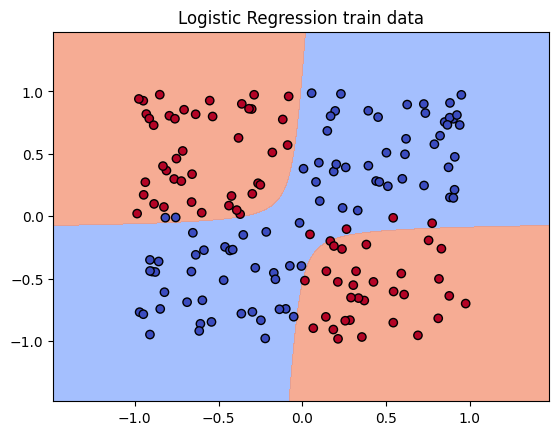

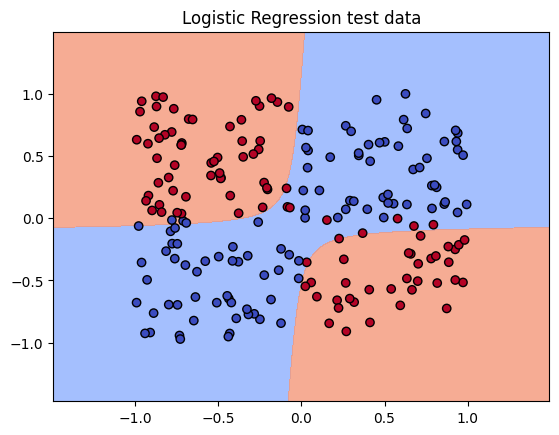

In [24]:
plot_decision_boundary(log_reg, X_train, y_train_tensor.numpy(), "Logistic Regression train data")
plot_decision_boundary(log_reg, X_test, y_test_tensor.numpy(), "Logistic Regression test data")


#Comments

1. By adding nonlinear features such as x1*x2, x1^2 , logistic regression can transform the XOR problem into a space where a linear model can effectively classify the points.
2. The model can fit a nonlinear decision boundary that better matches the XOR pattern, resulting in a more accurate classification on both training and test data.
3. The decision boundary resembles almost the correct XOR shape.